In [2]:
%matplotlib inline
!pip install nltk
!pip install seaborn
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
con = sqlite3.connect('database.sqlite') 

    100% |################################| 1.4MB 934kB/s eta 0:00:01
  Running setup.py bdist_wheel for nltk ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/d1/ab/40/3bceea46922767e42986aef7606a600538ca80de6062dc266c
Successfully built nltk
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |################################| 184kB 4.5MB/s ta 0:00:01
  Running setup.py bdist_wheel for seaborn ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/26/0a/44/53ddd89769e62f7c6691976375b86c6492e7dd20a2d3970e32
Successfully built seaborn
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
selected_data=pd.read_sql("select * from reviews",con)

In [4]:
selected_data.shape

(568454, 10)

In [5]:
selected_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Understanding of data:

### 1. Helpful numerator should be less than or equal to helfulness denominator..
### 2. Make sure that the same user cannot give the review for different products at the same unix time stamp..


In [6]:
### Trying out some queries..
number_of_unique_users=pd.value_counts(selected_data['UserId'])
print("Total_no_of_unique_users {}".format(len(number_of_unique_users)))

Total_no_of_unique_users 256059


In [7]:
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 

In [8]:
filtered_data.shape

(525814, 10)

In [9]:
def conversion_from_review_to_string(review):
    if review==4 or review==5:
        return 'positive'
    else:
        return 'negative'

In [10]:
## Trying to remove score column and replace it by +/- string..
filtered_data['Score']=filtered_data['Score'].map(conversion_from_review_to_string)

In [11]:
score=filtered_data['Score']
score.shape

(525814,)

In [12]:
filtered_data.drop('Score',axis=1,inplace=True)

In [13]:
filtered_data.shape

(525814, 9)

In [14]:
filtered_data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Time', 'Summary', 'Text'],
      dtype='object')

## DataCleaning...

In [15]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


### Here the user geetakrishna has given same review for different products at same time which needes to be deduped...

In [16]:
filtered_data=filtered_data.sort_values('ProductId',axis=0)
past_data_size=filtered_data.shape[0]
past_data_size

525814

In [17]:
filtered_data.drop_duplicates({'ProductId','UserId','ProfileName','Text'},inplace=True)
print(filtered_data.shape)
new_data_shape=filtered_data.shape[0]

(524587, 9)


In [18]:
data_loss=(past_data_size-new_data_shape)
print("Number of such duplicates are {}".format(data_loss))

Number of such duplicates are 1227


In [19]:
filtered_data=filtered_data[filtered_data.HelpfulnessNumerator<=filtered_data.HelpfulnessDenominator]

In [20]:
### So we have such duplicates this will affect the performance of the classifier
### Calculation the number of positive and negative reviews..
score.value_counts()

positive    443777
negative     82037
Name: Score, dtype: int64

## This is definitely an imbalanced dataset...

## Goal of the review is given a text we need to say whether a review is positive or not ..
### Applying the techniques of machine learning and natural language processing to solve this problem..

In [21]:
filtered_data['Text'][10]

"I don't know if it's the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind!  We picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away!  When we realized that we simply couldn't find it anywhere in our city we were bummed.<br /><br />Now, because of the magic of the internet, we have a case of the sauce and are ecstatic because of it.<br /><br />If you love hot sauce..I mean really love hot sauce, but don't want a sauce that tastelessly burns your throat, grab a bottle of Tequila Picante Gourmet de Inclan.  Just realize that once you taste it, you will never want to use any other sauce.<br /><br />Thank you for the personal, incredible service!"

## Text-Preprocessing..

### 1. Remove html tags as our text contains html tags..
### 2. Remove unnecessary punctuations..
### 3. Remove all the alphanumeric characters which do not help us in any way...
### 4. Remove words that has string length less than 2.
### 5. Remove stop words..
### 6. Apply stemming using snowball stemmer..
### 7. Finally lematize the word and lower it before adding in to clean text documnet...

In [22]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
nltk.download('stopwords')

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
{'and', 'your', 'now', 'most', "mustn't", 'been', 'these', 'him', 'of', 'shouldn', 'he', 'down', 'do', 'this', 'before', 'wasn', 'mightn', "that'll", 'themselves', 'herself', 'ma', 'in', 'our', 'ours', 'theirs', 'will', 'myself', 'for', 've', 'won', 'whom', 'were', 'few', 'between', 'having', 'again', 'what', "it's", 'being', 'its', 'wouldn', "wouldn't", 'why', 'd', 'couldn', "you'll", 'have', 'doing', 'the', 'any', 'needn', "mightn't", 'y', 'hadn', "couldn't", 'has', "you're", 'them', 'no', 'me', "weren't", 'his', 'each', 'how', 'by', 'same', 're', 'himself', 'yourselves', 'was', 'not', 'it', 'then', 'if', 'once', 'to', "don't", 'am', 'she', 'own', 'did', 'is', "should've", 'very', 'hers', 'while', 'aren', 'out', 'such', 'or', "haven't", 'isn', 'we', 'other', 'nor', 'who', "didn't", 'they', "she's", 'but', 'don', 'when', 'up', 'mustn', 'my', 'here', 'hasn', "isn't", 'w

In [23]:
len(score)

525814

In [24]:
filtered_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...


In [25]:
# Using Google News Word2Vectors
!pip install gensim
!pip install --upgrade pip
!pip install GoogleNews-vectors-negative300.bin
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.models import word2vec

import pickle
import os

    100% |################################| 22.2MB 63kB/s  eta 0:00:01
    100% |################################| 1.4MB 1.0MB/s eta 0:00:01
    100% |################################| 133kB 8.4MB/s eta 0:00:01
    100% |################################| 4.3MB 331kB/s eta 0:00:01
    100% |################################| 61kB 10.8MB/s ta 0:00:01
    100% |################################| 552kB 2.4MB/s eta 0:00:01
  Running setup.py bdist_wheel for gensim ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/2a/5f/2d/04fe5cffea90fbba14c8eab40f519096c8558cceaaa6777048
  Running setup.py bdist_wheel for smart-open ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/b1/9e/7d/bb3d3b55c597e72617140a0638c06382a5f17283881eae163e
  Running setup.py bdist_wheel for bz2file ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/81/75/d6/e1317bf09bf1af5a30befc2a007869fa6e1f516b8f7c591cb9
Successfully built gensim smart-open bz2file
You are using pip version 9.0.1, ho

In [26]:
import os
director=os.path.dirname(os.path.abspath("/downloads/GoogleNews-vectors-negative300.bin"))
print(director)

/downloads


In [27]:
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [28]:
model.wv['computer']

/opt/conda/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


array([  1.07421875e-01,  -2.01171875e-01,   1.23046875e-01,
         2.11914062e-01,  -9.13085938e-02,   2.16796875e-01,
        -1.31835938e-01,   8.30078125e-02,   2.02148438e-01,
         4.78515625e-02,   3.66210938e-02,  -2.45361328e-02,
         2.39257812e-02,  -1.60156250e-01,  -2.61230469e-02,
         9.71679688e-02,  -6.34765625e-02,   1.84570312e-01,
         1.70898438e-01,  -1.63085938e-01,  -1.09375000e-01,
         1.49414062e-01,  -4.65393066e-04,   9.61914062e-02,
         1.68945312e-01,   2.60925293e-03,   8.93554688e-02,
         6.49414062e-02,   3.56445312e-02,  -6.93359375e-02,
        -1.46484375e-01,  -1.21093750e-01,  -2.27539062e-01,
         2.45361328e-02,  -1.24511719e-01,  -3.18359375e-01,
        -2.20703125e-01,   1.30859375e-01,   3.66210938e-02,
        -3.63769531e-02,  -1.13281250e-01,   1.95312500e-01,
         9.76562500e-02,   1.26953125e-01,   6.59179688e-02,
         6.93359375e-02,   1.02539062e-02,   1.75781250e-01,
        -1.68945312e-01,

In [29]:
model.wv.similarity('woman', 'man')

/opt/conda/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


0.76640122309953529

In [30]:
model.wv.most_similar('woman')

/opt/conda/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


[('man', 0.7664012908935547),
 ('girl', 0.7494640946388245),
 ('teenage_girl', 0.7336827516555786),
 ('teenager', 0.6317086219787598),
 ('lady', 0.6288787126541138),
 ('teenaged_girl', 0.6141784191131592),
 ('mother', 0.6076306104660034),
 ('policewoman', 0.6069462299346924),
 ('boy', 0.5975908041000366),
 ('Woman', 0.5770982503890991)]

In [31]:
model.wv['amma'].shape

/opt/conda/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


(300,)

### Using google news data i train my word 2 vec model to visualize the tsne plot..

In [32]:
all_data_corpus=[]
for each_sent in filtered_data['Text'].values:
    filtered_words=[]
    good_text=cleanhtml(each_sent)
    for each_word in cleanpunc(good_text).split():
        if each_word.isalpha() and len(each_word)>2:
            filtered_words.append(each_word.lower())
        else:
            continue;
    all_data_corpus.append(" ".join(filtered_words))

In [33]:
print(len(all_data_corpus))

524585


In [34]:
sent_vectors = []; 
for sent in all_data_corpus: 
    sent_vec = np.zeros(300) 
    cnt_words =0;
    for word in sent:
        try:
            vec = model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

/opt/conda/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys
/opt/conda/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


524585
300


In [35]:
sent_vectors=pd.DataFrame(sent_vectors)

In [36]:
sent_vectors.shape

(524585, 300)

In [37]:
sent_vectors.dropna()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.172887,0.118275,-0.013194,0.130190,-0.042318,0.040172,-0.085347,-0.051452,-0.059480,0.014979,...,0.069310,0.008505,-0.090861,0.094120,-0.030638,-0.162411,-0.110070,-0.029023,-0.124112,0.153185
1,-0.163238,0.124352,-0.010728,0.147857,-0.024757,0.026223,-0.091209,-0.034006,-0.034438,0.008773,...,0.065813,-0.037931,-0.102466,0.116836,-0.028273,-0.156493,-0.096261,-0.014357,-0.105604,0.160009
2,-0.182117,0.138803,-0.027938,0.123491,-0.053132,0.031008,-0.102792,-0.041913,-0.049884,0.036115,...,0.083142,0.004432,-0.098177,0.093917,-0.016872,-0.161109,-0.120034,-0.027134,-0.135165,0.142764
3,-0.179468,0.123485,-0.025833,0.138386,-0.039202,0.032633,-0.095496,-0.046343,-0.039141,0.013509,...,0.063896,-0.000728,-0.088593,0.097149,-0.025152,-0.156340,-0.105813,-0.028227,-0.121545,0.150176
4,-0.189222,0.127867,-0.017690,0.131546,-0.056763,0.019824,-0.097402,-0.050992,-0.042568,0.024158,...,0.072543,0.001210,-0.089023,0.101351,-0.024643,-0.160058,-0.116926,-0.031576,-0.114586,0.157159
5,-0.179800,0.114023,-0.000323,0.136819,-0.060488,0.022464,-0.092163,-0.070864,-0.033064,0.007446,...,0.062095,0.011922,-0.087488,0.099072,-0.032415,-0.165144,-0.106257,-0.030238,-0.115027,0.154675
6,-0.179067,0.133336,-0.010377,0.134341,-0.044701,0.021888,-0.092264,-0.048518,-0.037975,0.013025,...,0.068036,-0.013076,-0.101703,0.104065,-0.030410,-0.165661,-0.101602,-0.030592,-0.104740,0.170930
7,-0.183033,0.131183,0.009964,0.140417,-0.033288,0.016109,-0.112759,-0.055294,-0.046456,0.014808,...,0.060451,-0.003138,-0.090247,0.120570,-0.039362,-0.154058,-0.114479,-0.024769,-0.113678,0.161582
8,-0.194260,0.108230,-0.005398,0.138725,-0.052741,0.011320,-0.083626,-0.068062,-0.029397,0.005412,...,0.055109,0.025628,-0.083131,0.096012,-0.043910,-0.171014,-0.118697,-0.031924,-0.104270,0.153483
9,-0.161649,0.127603,-0.004975,0.134913,-0.032712,0.049607,-0.098018,-0.044008,-0.051396,0.034331,...,0.086816,-0.011311,-0.089789,0.116954,-0.025344,-0.157795,-0.100604,-0.027036,-0.139249,0.146484


In [38]:
np.any(np.isnan(sent_vectors))

True

In [39]:
np.all(np.isfinite(sent_vectors))

False

In [40]:
sent_vectors.dropna(inplace=True)

In [41]:
sent_vectors.shape

(524577, 300)

In [42]:
from sklearn.manifold import TSNE
X = TSNE(n_components=2).fit_transform(sent_vectors[:25000])

In [43]:
tsne_data=np.c_[X,score[:25000]]
tsne_data.shape

(25000, 3)

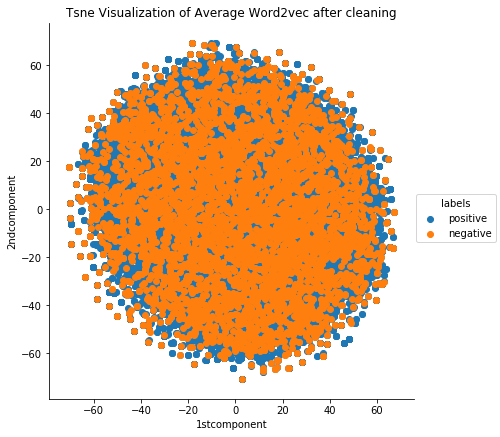

In [44]:
tsne_data=pd.DataFrame(tsne_data,columns=("1stcomponent","2ndcomponent","labels"))
import seaborn as sns
sns.FacetGrid(tsne_data,hue="labels",size=6).map(plt.scatter,"1stcomponent","2ndcomponent").add_legend()
plt.title("Tsne Visualization of Average Word2vec after cleaning")
plt.show()